In [1]:
import yfinance as yf
from fredapi import Fred
from config import get_fredapi_key

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# define fred api (using my personal api key)
fred = Fred(api_key = get_fredapi_key())

# Data Acquision

- SP500: https://finance.yahoo.com/quote/%5EGSPC/
- MY10Y: https://fred.stlouisfed.org/series/DGS10
- CPI: https://fred.stlouisfed.org/series/CPIAUCSL
- CSENT: https://fred.stlouisfed.org/series/UMCSENT
- IPM: https://fred.stlouisfed.org/series/IPMAN
- HOUSE: https://fred.stlouisfed.org/series/HSN1F
- UNEMP: https://fred.stlouisfed.org/series/UNRATE

In [2]:
"""

# Generate a date range from January 1950 to the present
date_range = date_range = pd.date_range(start='1950', end='2024', freq='M')

# Create Original data frame, wich Date, Year, Month columns
df_origin = pd.DataFrame({'Date': date_range})
df_origin['Year'] = df_origin['Date'].dt.year
df_origin['Month'] = df_origin['Date'].dt.month


### Data from Fred
# list of ids and column names of monthly data
ids = ['DGS10', 'CPIAUCSL', 'UMCSENT', 'IPMAN', 'HSN1F', 'UNRATE']
cols = ['MY10Y', 'CPI', 'CSENT', 'IPM', 'HOUSE', 'UNEMP']

# travering all pairs of ids and cols
for id, col in zip(ids, cols):
    # get the original data
    original = fred.get_series(id)
    # convert current index to column & change monthly data
    df_merge = original.resample('M').last().reset_index()
    # change column names
    df_merge.columns = ['Date', col]

    # merge two data frames
    df_origin = pd.merge(df_origin, df_merge, on='Date', how='left')


# Download S&P500 data as ticker "^GSPC" and convert to monthly data
sp500 = yf.download(['^GSPC'], start='1950-01-01').resample('M').last().reset_index()
# Add the close prices of S&P500 on each month
df_origin['SP500'] = sp500[sp500['Date'] >= '1950-01-31']['Close']

# download the original dataframe as csv
df_origin.to_csv('original.csv', index=False)

# show the first 5 rows
df_origin.head()

"""

'\n\n# Generate a date range from January 1950 to the present\ndate_range = date_range = pd.date_range(start=\'1950\', end=\'2024\', freq=\'M\')\n\n# Create Original data frame, wich Date, Year, Month columns\ndf_origin = pd.DataFrame({\'Date\': date_range})\ndf_origin[\'Year\'] = df_origin[\'Date\'].dt.year\ndf_origin[\'Month\'] = df_origin[\'Date\'].dt.month\n\n\n### Data from Fred\n# list of ids and column names of monthly data\nids = [\'DGS10\', \'CPIAUCSL\', \'UMCSENT\', \'IPMAN\', \'HSN1F\', \'UNRATE\']\ncols = [\'MY10Y\', \'CPI\', \'CSENT\', \'IPM\', \'HOUSE\', \'UNEMP\']\n\n# travering all pairs of ids and cols\nfor id, col in zip(ids, cols):\n    # get the original data\n    original = fred.get_series(id)\n    # convert current index to column & change monthly data\n    df_merge = original.resample(\'M\').last().reset_index()\n    # change column names\n    df_merge.columns = [\'Date\', col]\n\n    # merge two data frames\n    df_origin = pd.merge(df_origin, df_merge, on=\'Dat

In [3]:
# get original data from local file
df_origin = pd.read_csv('original.csv')
df_origin.head()

,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
0,1950-01-31,1950,1,NaN,23.51,NaN,NaN,NaN,6.5,17.049999
1,1950-02-28,1950,2,NaN,23.61,NaN,NaN,NaN,6.4,17.219999
2,1950-03-31,1950,3,NaN,23.64,NaN,NaN,NaN,6.3,17.290001
3,1950-04-30,1950,4,NaN,23.65,NaN,NaN,NaN,5.8,17.959999
4,1950-05-31,1950,5,NaN,23.77,NaN,NaN,NaN,5.5,18.780001


# Data Clearning & Modification

In [4]:
# dropping rows based on any missing data
df = df_origin.dropna()

# groupby dataframe based on "Year" and check the count
df.groupby('Year').count()[['Date']]

,Date
Year,
1972,4
1973,4
1974,4
1975,4
1976,4
1977,4
1978,12
1979,12
1980,12


In [5]:
# Based on the observation, the data between 1973 and 1977 has missing in some months.
# Thus, removing data between 1973 and 1977.
df = df[df['Year'] >= 1978].reset_index(drop=True)
df.head()

,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500
0,1978-01-31,1978,1,7.94,62.7,83.7,43.7471,795.0,6.4,89.250000
1,1978-02-28,1978,2,8.04,63.0,84.3,43.9139,791.0,6.3,87.040001
2,1978-03-31,1978,3,8.15,63.4,78.8,44.6899,814.0,6.3,89.209999
3,1978-04-30,1978,4,8.24,63.9,81.6,45.3905,864.0,6.1,96.830002
4,1978-05-31,1978,5,8.42,64.5,82.9,45.6235,857.0,6.0,97.239998


In [6]:
# Create categorical data;
#  whether the S&P500 rises (1) or falls(0) compared to a year ago
cat_values = (df['SP500'] > df['SP500'].shift(12)).astype(int)
cat_values[:12] = None
df['SP500_RISE'] = cat_values

# Changes to %YoY
chg_YoY = ['CPI', 'CSENT', 'IPM', 'HOUSE', 'SP500']
df.loc[:, chg_YoY] = df[chg_YoY].pct_change(12) * 100

# drop the rows with missing values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

df.head()

,Date,Year,Month,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP,SP500,SP500_RISE
0,1979-01-31,1979,1,8.95,9.250399,-13.859020,7.862464,-5.157233,5.9,11.966387,1.0
1,1979-02-28,1979,2,9.17,9.841270,-12.336892,7.786828,-8.596713,5.9,10.615806,1.0
2,1979-03-31,1979,3,9.11,10.252366,-13.197970,6.418676,-2.579853,5.8,13.877365,1.0
3,1979-04-30,1979,4,9.35,10.485133,-19.117647,2.997984,-13.425926,5.8,5.091398,1.0
4,1979-05-31,1979,5,9.06,10.697674,-17.852835,3.917937,-15.169195,5.6,1.892230,1.0


In [7]:
# comparisons between original and cleaned data
print('Dimensions:')
print(df_origin.shape, ' -> ', df.shape)
print('')
print('Total Missing Valies:')
print(df_origin.isna().sum().sum(), ' -> ', df.isna().sum().sum())

Dimensions:
(888, 10)  ->  (536, 11)

Total Missing Valies:
830  ->  0


In [8]:
# basic statistics (original)
features = ['SP500', 'MY10Y', 'CPI', 'CSENT', 'IPM', 'HOUSE', 'UNEMP']
df_origin[features].describe()

,SP500,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP
count,886.000000,742.000000,885.000000,640.000000,620.000000,728.000000,885.000000
mean,776.946704,5.874515,122.272904,85.612031,74.204909,655.686813,5.733672
std,1034.378161,2.992464,83.730383,12.870315,23.716954,208.464177,1.711406
min,17.049999,0.550000,23.510000,50.000000,35.254500,270.000000,2.500000
25%,88.822500,3.852500,34.700000,76.100000,50.362625,515.000000,4.400000
50%,248.285004,5.630000,110.400000,89.300000,81.475050,628.000000,5.500000
75%,1211.747528,7.635000,193.600000,95.000000,98.332150,765.250000,6.800000
max,4766.180176,15.840000,307.481000,112.000000,106.420200,1389.000000,14.700000


In [9]:
# basic statistics (current)
df[features].describe()

,SP500,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP
count,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000
mean,10.036841,5.773451,3.521761,0.397950,1.891457,1.482379,6.118843
std,15.923973,3.392282,2.760574,13.495788,4.906403,19.957188,1.779992
min,-44.756241,0.550000,-1.958761,-41.520468,-19.513084,-50.534759,3.400000
25%,2.039978,2.937500,1.896680,-6.602810,-0.218039,-10.908385,4.800000
50%,11.647982,5.070000,2.842673,0.250135,2.357958,2.704228,5.700000
75%,19.648005,8.020000,4.129461,6.696820,4.726355,13.571031,7.200000
max,53.714506,15.840000,14.592275,47.582205,20.819818,88.200590,14.700000


# Data Observation

### Correlation Matrix

In [10]:
# correlation Matrix
df[features].corr()

,SP500,MY10Y,CPI,CSENT,IPM,HOUSE,UNEMP
SP500,1.000000,0.040578,-0.020042,0.418819,0.398670,0.378325,0.026339
MY10Y,0.040578,1.000000,0.592328,0.132322,0.159296,-0.105760,0.280852
CPI,-0.020042,0.592328,1.000000,-0.230014,0.023860,-0.362648,0.008336
CSENT,0.418819,0.132322,-0.230014,1.000000,0.300586,0.402723,0.177823
IPM,0.398670,0.159296,0.023860,0.300586,1.000000,0.136040,-0.239208
HOUSE,0.378325,-0.105760,-0.362648,0.402723,0.136040,1.000000,0.142735
UNEMP,0.026339,0.280852,0.008336,0.177823,-0.239208,0.142735,1.000000


### Feature Reduction

In [11]:
# create a new feature and insert it 
df.insert(loc=9, column='LRIR', value=df['MY10Y'] - df['CPI'])

# drop MY10Y and CPI
df.drop(['MY10Y', 'CPI'], axis=1, inplace=True)

# show new dimension
print("New Dimension: ", df.shape)

# show new correlation matrix
features = ['SP500','CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR']
df[features].corr()

New Dimension:  (536, 10)


,SP500,CSENT,IPM,HOUSE,UNEMP,LRIR
SP500,1.000000,0.418819,0.398670,0.378325,0.026339,0.068081
CSENT,0.418819,1.000000,0.300586,0.402723,0.177823,0.382374
IPM,0.398670,0.300586,1.000000,0.136040,-0.239208,0.167405
HOUSE,0.378325,0.402723,0.136040,1.000000,0.142735,0.226617
UNEMP,0.026339,0.177823,-0.239208,0.142735,1.000000,0.327998
LRIR,0.068081,0.382374,0.167405,0.226617,0.327998,1.000000


### Correlation Plots

C:\Users\runru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


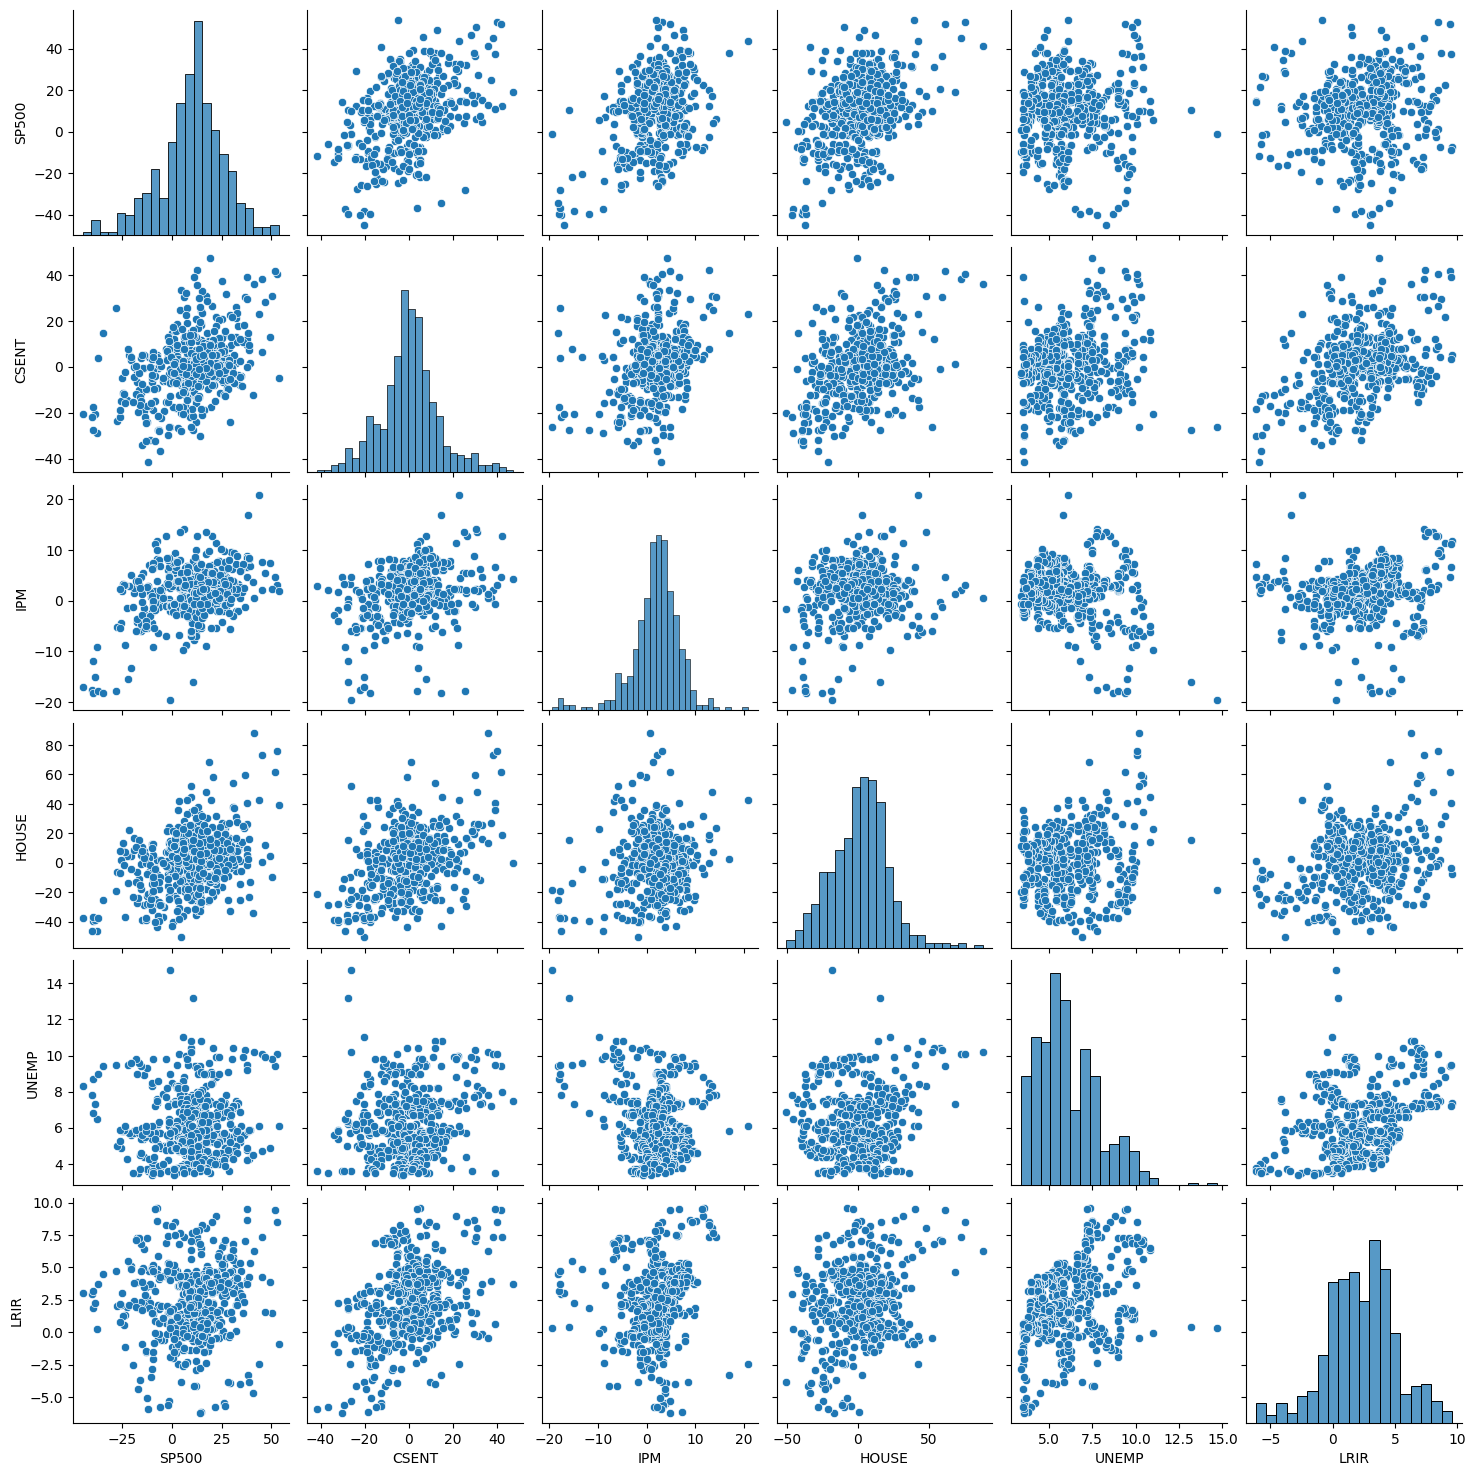

In [12]:
# check correlation 
sns.pairplot(df[features])

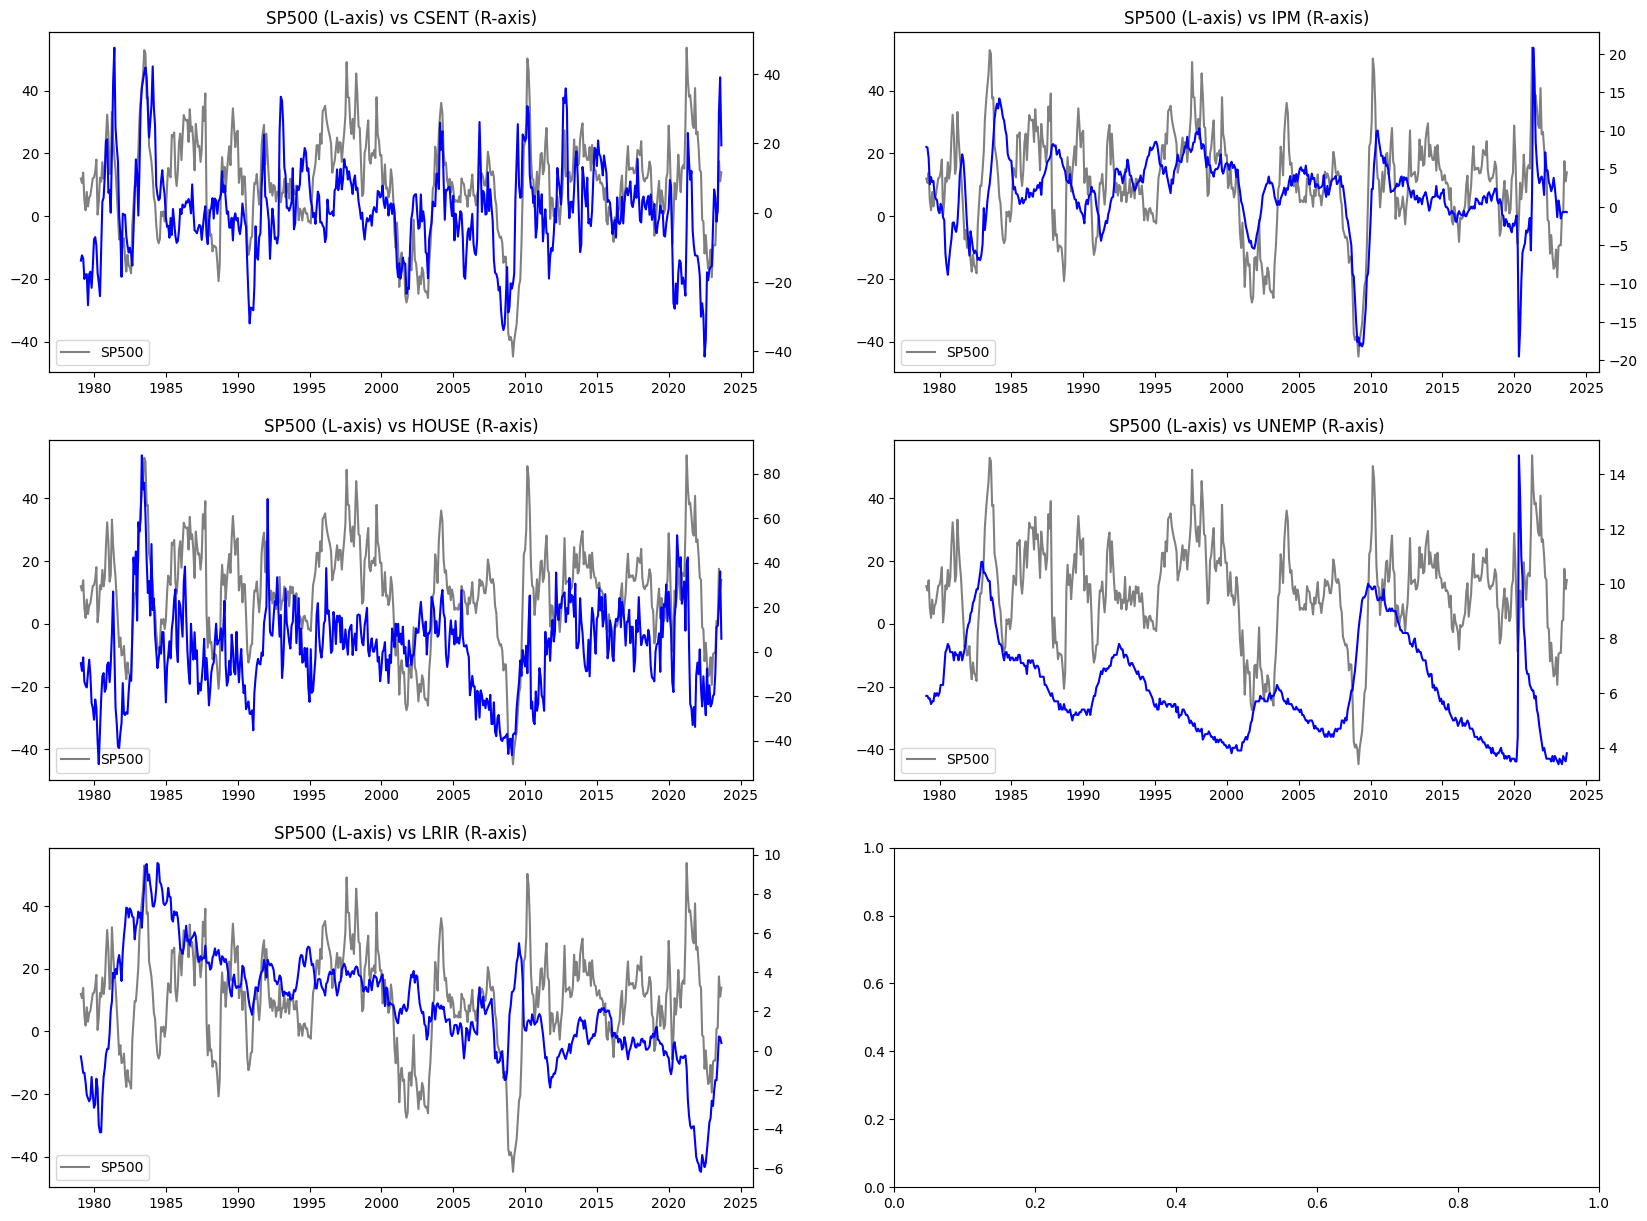

In [14]:
# Observing the relationships between S&P500 idex and economic indicators
rows, cols = 3, 2

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 15))

for idx, d in enumerate(features[1:]):
    i, j = idx // cols, idx % cols
    # plot two line charts
    ax[i][j].plot(pd.to_datetime(df['Date']), df['SP500'], color='grey', label='SP500')
    ax[i][j].twinx().plot(pd.to_datetime(df['Date']), df[d], color='blue', label=d)
    ax[i][j].set_title(f"SP500 (L-axis) vs {d} (R-axis)")
    ax[i][j].legend()


C:\Users\runru\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


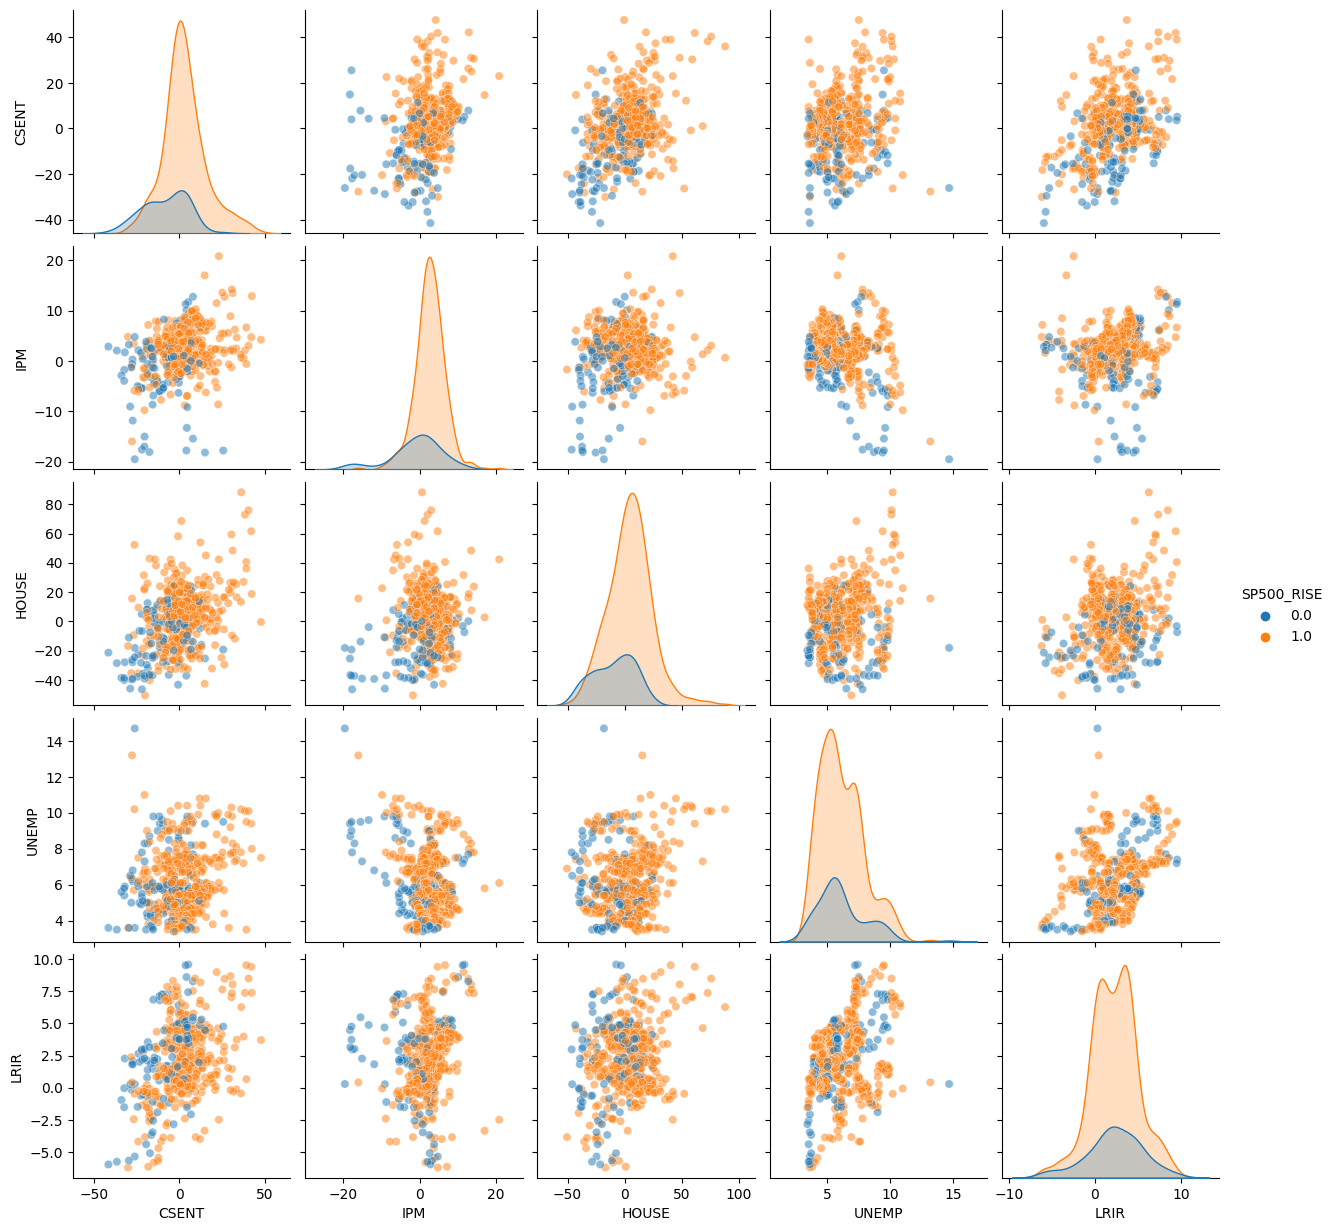

In [15]:
# Check the pairs (two independent variables) of the scatter plots based on the categorical data.
indicators = ['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR']
sns.pairplot(df[indicators + ['SP500_RISE']], hue='SP500_RISE', plot_kws={'alpha': 0.5})

Text(0.5, 0.98, 'Whether the S&P500 Rises from Previous Year (Green) or not (Red)')

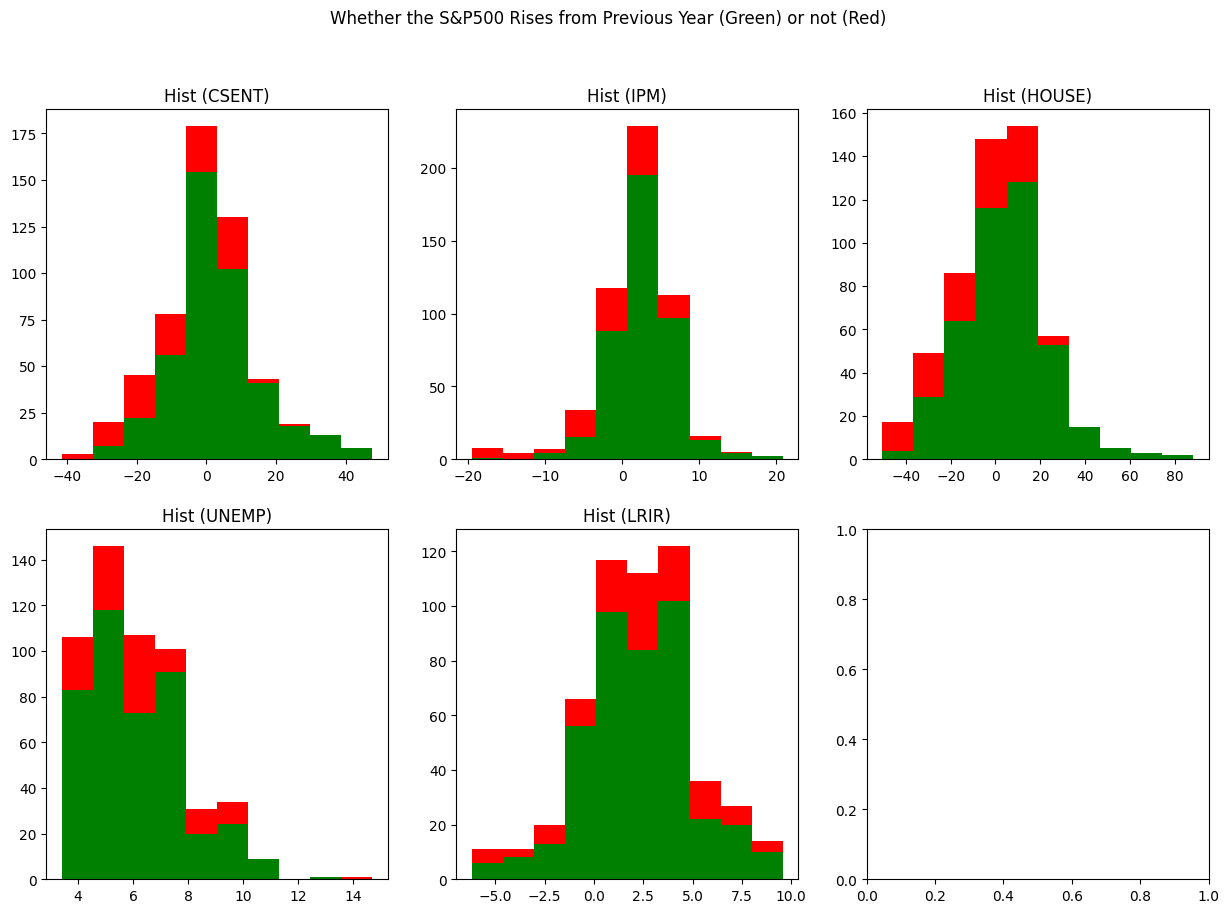

In [16]:
# Check histogram of each independent variable based on the ratio of categorical data.
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, data in enumerate(['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR']):
    i1, i2 = i // 3, i % 3
    rise = df[df['SP500_RISE'] == 1.0][data]
    fall = df[df['SP500_RISE'] == 0.0][data]
    ax[i1][i2].hist([rise, fall], color=['green', 'red'], stacked=True)
    ax[i1][i2].set_title(f'Hist ({data})')

plt.suptitle('Whether the S&P500 Rises from Previous Year (Green) or not (Red)')

# Dataset Creation
- Four types of moving averages will be applied to every data:; 0-, 3-, 6-, 12-month.

In [ ]:
# create dictionary of dataframe
df_dict = {}
# define column names for each x and y from "df"
col_Y = 'SP500_%YoY'
col_X = ['MY10Y_%YoY', 'CPI_%YoY', 'CSENT_%YoY', 'IPM_%YoY', 'HOUSE_%YoY', 'UNEMP']

# row shifts
for s in [1,2,3]:
    # copy current df
    new_df = df.copy()
    # shifting row(s)
    new_df = new_df[col_X].shift(s)

    # different moving average
    for ma in [0, 3, 6, 12]:
        pass

# Model Creation

### Multiple linear Regression
- Applying online and batch learnings
- Three dataset options for 1-, 2-, 3-month forward prediction.
- Evaluate each model by the following measures:
    - Root of mean squared error
    - 
- Feature reduction by backward elimination for whole models.

In [175]:
class Standardization:
    def __init__(self):
        #initialize all variables
        self.mu_old = 0
        self.sd_old = 0
        self.mu = 0
        self.sd = 0
        self.t = 0
        self.X = np.array([])
        self.X_ss = np.array([])

    def fit_transform(self, t, X):
        """
        Standarize X features by mean and std of the time periods of "t", then return the standardized features.
        
        Parameters:
        "t": int -> observing time ranges or number of data; a window of data
        "X": np.array -> matrix of independent variables.
        """
        # store all given parameters
        self.t = t
        self.X = X
        self.X_ss = np.zeros(X.shape)

        # initial standardization
        self.mu, self.sd = np.mean(X[0:t], axis=0), np.std(X[0:t], axis=0)
        self.X_ss[0:t] = (X[0:t] - self.mu) / self.sd

        # standarize new feature one by one
        for i, idx in enumerate(range(t, len(X))):
            # assign a series of newly standardized features
            self.X_ss[idx] = self.update(x_del=X[i], x_new=X[idx])

        return self.X_ss
        

    def transform(self, x):
        """
        Return value is the same as self.update().
        A given series of features ("x") is added to the stored feature matrix.

        This function is invoked everytime when a new series of new features.
        Make sure the consistency of the time series data. 

        Parameter:
        - "x": np.array -> a series of newly updated features and has never been add in self.X 
        """
        # a series of deleted features 
        x_del = self.X[-self.t]
        # update X
        self.X = np.append(self.X, x)
        # assign standardized features
        new_features = self.update(x_del=x_del, x_new=x)
        self.X_ss = np.append(self.X_ss, new_features)

        return new_features


    def update(self, x_del, x_new):
        """
        Return a series of standardized features one by one based on the mean and std of the most recent "self.t" number of data.
        In other words, a series of new features are standardized by the moving average and std over the "self.t" periods.

        Paratermers:
        - "x_del": np.array([]) -> a series of unscoped features.
        - "x_new": np.array([]) -> a series of the most recent features.
        """
        # assign current mean and std as old ones
        self.mu_old, self.sd_old = self.mu, self.sd
        # newly deleted features will be at -120 from the current feature matrix
        self.mu = self.mu_old + (x_new - x_del) / self.t
        self.sd = np.sqrt(((self.t-1)*self.sd_old**2 - (x_del - self.mu_old)**2 + (x_new - self.mu)**2) / (self.t-1))
        # assign standardized features
        new_features = (x_new - self.mu) / self.sd

        return new_features

In [176]:
# define column names of all features
x_cols = ['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR']
# assigning X and y
X = np.array(df[x_cols])
y = np.array(df[['SP500']])

# standardization
scaler = Standardization()
X_ss = scaler.fit_transform(120, X)

RMSE: 9.4536%


Text(0.5, 1.0, 'Comparison of Predicted and Actual S&P500 index')

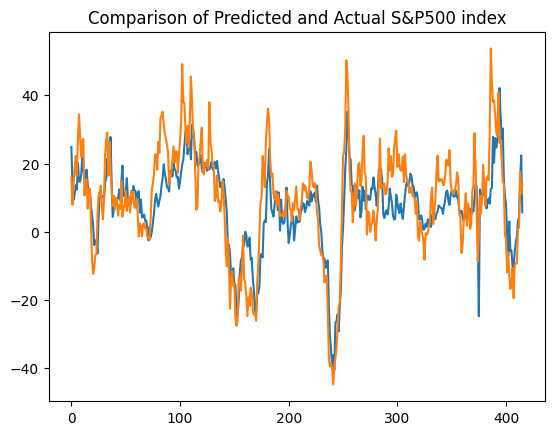

In [177]:
def online_learning(t, X, y, alpha=0.01, lambda_=0.5):
    """
    Return the following three matrix (dtype: np.array)
    - "theta"  -> parameters (intercept + coefficients) at each step
    - "y_hats" -> predicted values at each step
    - "sigma"  -> prediction errors (actual - predicted values); SSE

    Parameters:
    - "t": int -> number of months that were used for the initial training data.
    - "X": np.array -> independent variables
    - "y": np.array -> target variables
    - "alpha": learning rate for gradient descent
    - "lambda_": hyperparameter for the elastic net regularization.

    Brief Steps:
    - Initialize matries for theta, y_hats, sigma.
    - Apply a given time ranges ("t") of the dataset to the mutiple linear regression.
    - Define the initial parameters from the trained model.
    - For each new data point (incremental learning):
        - Predict the target; "y_hats".
        - Calculate the difference between actual and predicted values; "sigma"
        - Update parameters by (stochastic) gradient descent with elastic regularization; "theta"
    """
    # initial training
    init_X, init_y = X[0:t], y[0:t]
    # training the initial data
    model = LinearRegression()
    model.fit(init_X, init_y)

    # define all matrix to be returned
    theta = np.zeros((len(y)-t + 1, 6))
    y_hats = np.zeros((len(y)-t, 1))
    sigma = np.zeros((len(y)-t, 1))
    # obtain the initial parameters
    theta[0] = np.append(model.intercept_, model.coef_)
    
    # incremental learnings
    for i, idx in enumerate(range(t, len(y))):
        # get new data (X_i includes bias)
        X_i, y_i = np.append(np.array([1]), X[idx]) , y[idx]
        # predicted variable
        y_hats[i] = np.dot(theta[i], X_i)
        # predicted error
        sigma[i] =  (y_i - y_hats[i])
        # the gradient of the loss function with respect to the new observation (normal: X_i * sigma[i])
        gradient = -2 * X_i * sigma[i] + 2 * lambda_ * theta[i] + (1-lambda_) * np.sign(theta[i])
        # update all parameters by stochastic gradient descent
        theta[i+1] = theta[i] - alpha * gradient

    return theta, y_hats, sigma

theta1, y_hats1, sigma1 = online_learning(t=120, X=X_ss, y=y)

rmse1 = np.sqrt(sum(sigma1**2) / len(sigma1))
print(f"RMSE: {rmse1[0]:.4f}%")

plt.plot(y_hats1)
plt.plot(y[120:])
plt.title('Comparison of Predicted and Actual S&P500 index')

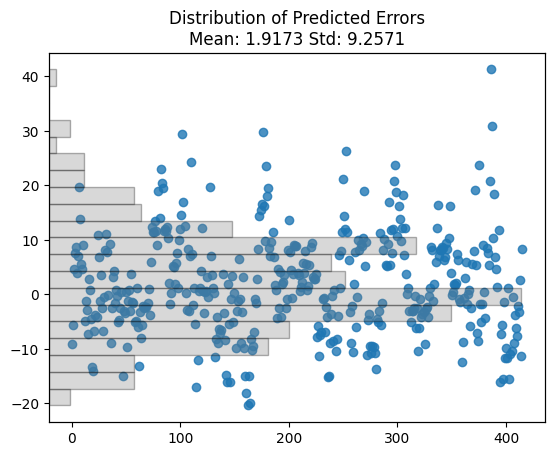

In [144]:
plt.scatter(range(len(sigma1)), sigma1, alpha=0.8)
ax2 = plt.twiny()
ax2.hist(sigma1, orientation='horizontal', bins=20, 
         alpha=0.3, color='grey', edgecolor='black')
ax2.xaxis.set_visible(False)
plt.xlabel('Time Periods (Month)')
plt.ylabel('Difference of Percentage Growth')
plt.title(f'Distribution of Predicted Errors\nMean: {sigma1.mean():.4f} Std: {sigma1.std():.4f}')
plt.show()

RMSE: 12.0202%


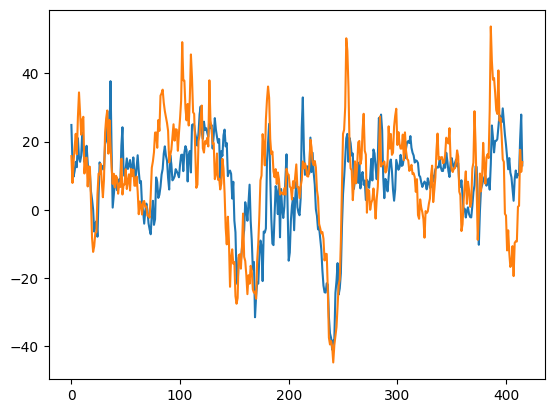

In [147]:
def batch_learning(t, X, y, labmda_=0.5):
    """
    Return the following three matrix (dtype: np.array)
    - "theta"  -> parameters (intercept + coefficients) at each step
    - "y_hats" -> predicted values at each step
    - "sigma"  -> prediction errors

    Parameters:
    - "t": int -> number of months that were used for the initial training data.
    - "X": np.array -> independent variables
    - "y": np.array -> target variables
    - "lambda_": hyperparameter for the elastic net regularization.

    Brief Steps:
    - Initialize matries for theta, y_hats, sigma.
    - Train the model with a given time ranges ("t") of the dataset.
    - For each new data point (batch learning):
        - get all parameters (intercept and coefficients) by the least square method; "theta"
        - Predict the target value; "y_hats".
        - Calculate the difference between actual and predicted values; "sigma"
    """
    # define all matrix to be returned
    theta = np.zeros((len(X)-t + 1, 6))
    y_hats = np.zeros((len(X)-t, 1))
    sigma = np.zeros((len(X)-t, 1))

    # batch learning
    for i, idx in enumerate(range(t, len(X))):
        # get the recent "t" months data (X_i includes bias)
        X_i, y_i = np.insert(X[i:idx], 0, 1, axis=1) , y[i:idx]
        # fit the training data
        theta[i] = np.linalg.inv(X_i.T.dot(X_i)).dot(X_i.T).dot(y_i).reshape(1,-1)
        # predicted value
        X_new = np.append(np.array([1]), X[idx])
        y_hats[i] = np.dot(theta[i], X_new)
        # predicted error
        sigma[i] = y[idx] - y_hats[i]

    # trained the most recent data
    last = len(y)
    X_i, y_i = np.insert(X[last-t:last], 0, 1, axis=1) , y[last-t:last]
    theta[last-t] = np.linalg.inv(X_i.T.dot(X_i)).dot(X_i.T).dot(y_i).reshape(1,-1)

    return theta, y_hats, sigma

theta2, y_hats2, sigma2 = batch_learning(t=120, X=X_ss, y=y)

rmse2 = np.sqrt((sigma2**2).mean())
print(f"RMSE: {rmse2:.4f}%")

plt.plot(y_hats2)
plt.plot(y[120:])

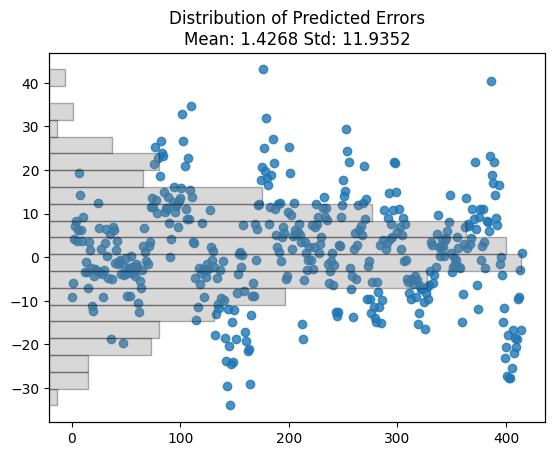

In [148]:
plt.scatter(range(len(sigma2)), sigma2, alpha=0.8)
ax2 = plt.twiny()
ax2.hist(sigma2, orientation='horizontal', bins=20, 
         alpha=0.3, color='grey', edgecolor='black')
ax2.xaxis.set_visible(False)
plt.xlabel('Time Periods (Month)')
plt.ylabel('Difference of Percentage Growth')
plt.title(f'Distribution of Predicted Errors\nMean: {sigma2.mean():.4f} Std: {sigma2.std():.4f}')
plt.show()

In [149]:
def evaluation(t, X, y, theta, y_hats, sigma):
    """
    Return the data frame; the following measureas by brackward eliminations:
    - Root Mean Square Error (rmse)
    - Standatd Error of Estimate (se)
    - Coefficient of Determination (r2)
    - Adjusted Coefficient of Determination (adj_r2)

    Parameters:
    - "t": number of months that were used for the initial training data.
    - "X": independent variables
    - "y": the actual target value (whole period)
    - "theta": all parameters (intercept & coefficients) at each step
    - "y_hats": the predicted target value at each step
    - "sigma": difference between actual and predicted values at each step

    Requirement: len(y[t:]) == len(y_hats)
    """
    # (0): Define Variables
    #  number of observations and features (excluding bias)
    n, k = len(y_hats), len(theta[0]) - 1
    #  measures matrix
    mm = np.zeros((k+1, 4))
    # assign the data frame index and columns
    rows = ['original'] + [f'theta{i+1}=0' for i in range(k)]
    cols = ['rmse', 'se', 'r2', 'adj_r2']
    #  mean of actual "y" over the "t" months
    #y_mean = np.array([y[i:i+t].mean() for i in range(len(y)-t)]).reshape(-1, 1)
    y_mean = np.mean(y[t:])
    #  sum of square total
    sst = np.sum((y[t:] - y_mean)**2)
    #  define feature matrix and target based on "t"
    X_, y_ = np.insert(X[t:], 0, 1, axis=1), y[t:]

    #  number of coefficients
    for i in range(k+1):
        # simply applying the given sigma
        if i == 0:
            sigma_ = sigma
        # conduct the backward elimination
        else:
            # copy the parameters matrix
            theta_ = theta[:n].copy()
            # change a particular coefficient to 0 arbitrarily.
            theta_[:, i] = 0
            # based on revised parameters, get the predicted value
            y_hats_ = np.sum(X_ * theta_, axis=1).reshape(-1, 1)
            # predicted error
            sigma_ = y_ - y_hats_    
    
        # Calculate Measures (rmse, se, r2, adj_r2, in order)
        sse = np.sum(sigma_**2)
        mm[i, 0] = np.sqrt((sigma_**2).mean()) 
        mm[i, 1] = np.sqrt(sse / (n - k - 1))
        mm[i, 2] = 1 - sse/sst
        mm[i, 3] = 1 - (sse/(n - k -1))/(sst/(n-1))
         
    return pd.DataFrame(data=mm, index=rows, columns=cols)


In [154]:
print('Online Learning:')
print(' No Data Shift & 0-month Moving Average')
evaluation(120, X_ss, y, theta1, y_hats1, sigma1)

Online Learning:
 No Data Shift & 0-month Moving Average


,rmse,se,r2,adj_r2
original,9.453580,9.522502,0.642370,0.638009
theta1=0,11.127814,11.208941,0.504481,0.498438
theta2=0,10.428650,10.504680,0.564792,0.559484
theta3=0,10.464609,10.540901,0.561785,0.556441
theta4=0,10.903465,10.982957,0.524260,0.518458
theta5=0,10.737406,10.815687,0.538640,0.533014


In [150]:
print('Batch Learning: ')
print(' No Data Shift & 0-month Moving Average')
evaluation(120, X_ss, y, theta2, y_hats2, sigma2)

Batch Learning: 
 No Data Shift & 0-month Moving Averate


,rmse,se,r2,adj_r2
original,12.020190,12.107824,0.421819,0.414768
theta1=0,13.496321,13.594716,0.271094,0.262205
theta2=0,12.761974,12.855015,0.348257,0.340309
theta3=0,12.837324,12.930915,0.340538,0.332495
theta4=0,13.343004,13.440281,0.287560,0.278872
theta5=0,12.367184,12.457347,0.387956,0.380492


5

In [381]:
# define column names for independent variables
x_cols = ['CSENT', 'IPM', 'HOUSE', 'UNEMP', 'LRIR']

model = LinearRegression()

# predicted %YoY growths after each month based on the last 10 years data
date = df['Date'].iloc[120:].values
est_growth = {'0M': [],'1M': [np.nan], '2M': [np.nan]*2, '3M': [np.nan]*3}
future = {'0M': [], '1M': [], '2M': [], '3M': []}
# test data index

for m in [0,1,2,3]:
    # shift data for each month
    df_shift = df.copy()
    df_shift['SP500'] = df['SP500'].shift(-m)
    # create train and test data
    for i in range(120, len(df)-m):
        # define start index
        s = i - 120
        train = df_shift.iloc[s:i]
        test = df_shift.iloc[i:i+1]

        # define model
        model = LinearRegression()
        # fit the data
        model.fit(train[x_cols], train['SP500'])
        # get and predicted value and store it to dict
        est_growth[f'{m}M'] += list(model.predict(test[x_cols]))
    
    # add the rest of feature(s)
    future[f'{m}M'] += list(model.predict(df_shift.iloc[-m:][x_cols])) 

In [231]:
result_df = df[['Date', 'SP500']].iloc[120:].reset_index(drop=True)
# add predicted growth
for k in est_growth.keys():
    result_df[f"Est_{k}_Ago"] = est_growth[k]
result_df.head()

,Date,SP500,Est_1M_Ago,Est_2M_Ago,Est_3M_Ago
0,1989-01,15.715561,NaN,NaN,NaN
1,1989-02,7.856014,24.660302,NaN,NaN
2,1989-03,13.897786,12.531227,22.899435,NaN
3,1989-04,18.486217,9.114212,11.757725,22.306831
4,1989-05,22.261209,11.153234,8.972035,11.393356


In [232]:
result_df.tail()

,Date,SP500,Est_1M_Ago,Est_2M_Ago,Est_3M_Ago
411,2023-04,0.908772,2.687153,3.438394,2.489983
412,2023-05,1.153883,5.561697,2.336005,4.000293
413,2023-06,17.567590,6.732435,5.110040,3.151268
414,2023-07,11.105029,11.939503,7.009820,5.578984
415,2023-08,13.973708,15.989454,11.825849,7.337735


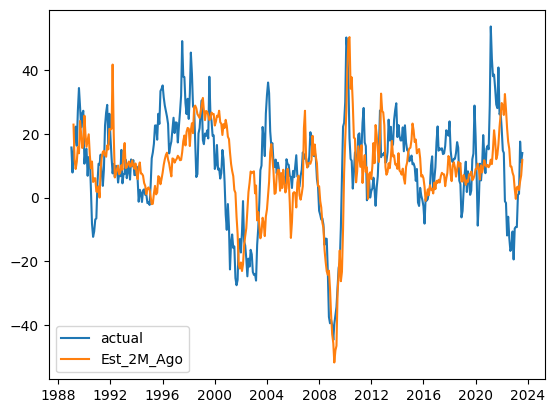

In [275]:
plt.plot(pd.to_datetime(result_df['Date']), result_df['SP500'], label='actual')
plt.plot(pd.to_datetime(result_df['Date']), result_df['Est_2M_Ago'], label='Est_2M_Ago')
plt.legend()

In [271]:
future

{'1M': [8.674979625958029],
 '2M': [15.35483201095332, 8.707772307491057],
 '3M': [13.59716455647952, 17.544255000982595, 10.17739639106059]}

In [259]:
for a, b in zip([3585.620117, 3871.979980, 4080.110107], future):
    growth = (b/100) + 1
    print(a*growth)


3896.671931614002
4209.143180450038
4495.359085781116


Elastic regularization is a method of adding a penalty term to the loss function of a linear or logistic regression model, which helps to prevent overfitting and improve generalization. The penalty term is a linear combination of the L1-norm and the L2-norm of the model coefficients, which are also known as the elastic net coefficients. The L1-norm encourages sparsity, meaning that some coefficients can be shrunk to zero and eliminated from the model. The L2-norm encourages smoothness, meaning that the coefficients are kept small and close to each other.

The elastic net loss function can be written as:

$$
L(\beta) = \sum_{i=1}^n (y_i - x_i^T \beta)^2 + \lambda_1 \sum_{j=1}^p |\beta_j| + \lambda_2 \sum_{j=1}^p \beta_j^2
$$

where $\beta$ is the vector of elastic net coefficients, $x_i$ is the vector of features for the $i$-th observation, $y_i$ is the response variable for the $i$-th observation, $n$ is the number of observations, $p$ is the number of features, $\lambda_1$ and $\lambda_2$ are the regularization parameters that control the strength of the L1 and L2 penalties, respectively.

To find the optimal values of $\beta$, we need to minimize the loss function with respect to $\beta$. This can be done using gradient descent, which is an iterative algorithm that updates $\beta$ by moving in the opposite direction of the gradient of the loss function. The gradient of the loss function is given by:

$$
\nabla L(\beta) = -2 \sum_{i=1}^n x_i (y_i - x_i^T \beta) + 2 \lambda_2 \beta + \lambda_1 s
$$

where $s$ is a vector of signs of $\beta$, such that $s_j = sign(\beta_j)$ for $j = 1, ..., p$. The sign function is defined as:

$$
sign(x) = \begin{cases}
-1 & \text{if } x < 0 \\
0 & \text{if } x = 0 \\
1 & \text{if } x > 0
\end{cases}
$$

The gradient descent update rule for $\beta$ is:

$$
\beta^{(t+1)} = \beta^{(t)} - \alpha \nabla L(\beta^{(t)})
$$

where $\alpha$ is the learning rate, which determines how big of a step to take in each iteration, and $t$ is the iteration number.

Now, suppose we have already found an optimal value of $\beta$ using some existing data, and we want to update it by adding one new observation $(x_{n+1}, y_{n+1})$. How does elastic regularization affect this update?

To answer this question, we need to compare the loss function before and after adding the new observation. The loss function before adding the new observation is:

$$
L(\beta) = \sum_{i=1}^n (y_i - x_i^T \beta)^2 + \lambda_1 \sum_{j=1}^p |\beta_j| + \lambda_2 \sum_{j=1}^p \beta_j^2
$$

The loss function after adding the new observation is:

$$
L'(\beta) = \sum_{i=1}^{n+1} (y_i - x_i^T \beta)^2 + \lambda_1 \sum_{j=1}^p |\beta_j| + \lambda_2 \sum_{j=1}^p \beta_j^2
$$

The difference between these two loss functions is:

$$
\Delta L(\beta) = L'(\beta) - L(\beta) = (y_{n+1} - x_{n+1}^T \beta)^2
$$

This means that adding a new observation only affects the loss function by adding a squared error term. The regularization terms do not change because they do not depend on the data.

Therefore, to update $\beta$ by adding a new observation, we only need to apply one step of gradient descent using the new observation. The gradient of the loss function with respect to the new observation is:

$$
\nabla L'(\beta) = -2 x_{n+1} (y_{n+1} - x_{n+1}^T \beta) + 2 \lambda_2 \beta + \lambda_1 s
$$

The gradient descent update rule for $\beta$ with respect to the new observation is:

$$
\beta^{(t+1)} = \beta^{(t)} - \alpha \nabla L'(\beta^{(t)})
$$

This update rule shows that elastic regularization affects the update of $\beta$ by adding two terms: $2 \lambda_2 \beta$ and $\lambda_1 s$. The first term is the same as in ridge regression, which shrinks $\beta$ towards zero by a factor of $2 \lambda_2$. The second term is the same as in lasso regression, which shrinks $\beta$ towards zero by a constant amount of $\lambda_1$, but also changes the sign of $\beta$ if it is close to zero. This term can cause some coefficients to become exactly zero and be eliminated from the model.

In summary, elastic regularization affects the update of $\beta$ by adding one new observation by applying one step of gradient descent using the new observation and the regularization terms. The regularization terms help to prevent overfitting and improve generalization by shrinking and sparsifying $\beta$.

Source: Conversation with Bing, 10/20/2023
(1) Elastic net regularization - Wikipedia. https://en.wikipedia.org/wiki/Elastic_net_regularization.
(2) Elastic Net Regression Explained, Step by Step - Machine Learning Compass. https://machinelearningcompass.com/machine_learning_models/elastic_net_regression/.
(3) Elastic Net - Overview, Geometry, and Regularization. https://corporatefinanceinstitute.com/resources/data-science/elastic-net/.

<hr style="border:2px solid gray">

Sure, if the first column of the matrix **X_** is a bias term (all ones for instance), and the vector **theta_** includes the parameter **theta_0**, then the matrix multiplication will account for this bias term. 

Here's how it looks in matrix form:

$$
\begin{bmatrix}
1 & x_{12} & \cdots & x_{1n} \\
1 & x_{22} & \cdots & x_{2n} \\
\vdots & \vdots & \ddots & \vdots \\
1 & x_{m2} & \cdots & x_{mn}
\end{bmatrix}
\begin{bmatrix}
\theta_0 \\
\theta_1 \\
\vdots \\
\theta_n
\end{bmatrix}
=
\begin{bmatrix}
\theta_0 + x_{12}\theta_1 + \cdots + x_{1n}\theta_n \\
\theta_0 + x_{22}\theta_1 + \cdots + x_{2n}\theta_n \\
\vdots \\
\theta_0 + x_{m2}\theta_1 + \cdots + x_{mn}\theta_n
\end{bmatrix}
$$

Each element in the resulting vector is the sum of the products of corresponding elements in a row of **X** and the vector **θ**, including the bias term **θ0**. This is essentially a dot product operation performed for each row of **X** with **θ**, taking into account the bias. This operation is often used in machine learning algorithms such as linear regression.